(confidence-interval-notebook)=
# Intervallo di confidenza

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import arviz as az
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [99]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
sns.set_theme(
    context="paper",
    palette="colorblind"
)
az.style.use("arviz-darkgrid")

Come esempio di applicazione dell'approccio frequentista a un problema, consideriamo il compito di stimare la media $\mu$ di una popolazione basandosi su un campione di dati. In questo caso, l'obiettivo è utilizzare i dati del campione per fare inferenze sul parametro $\mu$ della popolazione.

Iniziamo con il ricordare che il problema nasce dal fenomeno della variabilità campionaria.

## La variabilità campionaria

Per riassumere, quando si prende un campione casuale da una popolazione, la statistica calcolata su quel campione sarà diversa dal parametro della popolazione a causa della variabilità campionaria. Per valutare l'errore nella stima del parametro, l'approccio frequentista utilizza l'errore standard, che rappresenta l'incertezza relativa alla stima del parametro, calcolata come deviazione standard della distribuzione della statistica nell'universo dei campioni. L'errore standard quantifica l'incertezza della stima, che sarà maggiore se l'errore standard è grande. L'approccio frequentista utilizza l'errore standard per costruire l'intervallo fiduciale, che fornisce una stima dell'intervallo di valori in cui ci si aspetta che il parametro cada con una certa probabilità.

## L'errore standard

Per fare un esempio concreto, immaginiamo di voler valutare la variabilità della proporzione di studenti che superano l'esame di Psicometria all'Università di Firenze, considerando tutti gli appelli d'esame passati, presenti e futuri. Poiché non disponiamo di dati osservati ma solo di una distribuzione teorica, è necessario utilizzare l'errore standard come misura di dispersione della statistica di interesse, invece della deviazione standard. L'errore standard rappresenta la variazione della statistica campionaria nell'universo dei campioni, ovvero l'insieme teorico di tutti i possibili campioni che possono essere estratti dalla popolazione. È importante notare che in questo caso l'universo dei campioni è solo un'entità teorica, non un insieme reale di dati osservati.

Per valutare la precisione della stima di una statistica campionaria, l'errore standard svolge un ruolo fondamentale. Un errore standard basso indica una buona precisione della stima e una maggiore affidabilità del parametro di interesse nei diversi campioni. Al contrario, un errore standard elevato suggerisce una minore precisione della stima e una maggiore incertezza del parametro nei diversi campioni. 

Il calcolo dell'errore standard viene eseguito utilizzando un software statistico e può essere descritto come una misura dell'inverso della curvatura della funzione di verosimiglianza nella stima di massima verosimiglianza del parametro $\theta$. Per capire meglio questa definizione, consideriamo la figura seguente. Nel pannello di sinistra, è mostrata la funzione di verosimiglianza per 10 prove Bernoulliane con 7 successi. Nel pannello centrale, è rappresentata la verosimiglianza per 100 prove con 70 successi e nel pannello di destra abbiamo la verosimiglianza per 1000 prove con 700 successi.

![](images/likelihood_and_SE.png)

Sinistra: funzione di verosimiglianza nel caso di 7 successi in 10 prove Bernoulliane; centro: funzione di verosimiglianza nel caso di 70 successi in 100 prove; destra: funzione di verosimiglianza nel caso di 700 successi in 1000 prove.

La figura illustra la funzione di verosimiglianza per diverse combinazioni di successi e prove in un esperimento Bernoulliano. Quando il numero di prove aumenta, l'incertezza nella stima del parametro di probabilità di successo (o proporzione campionaria) diminuisce e la curvatura della funzione di verosimiglianza aumenta. Questo significa che un campione più grande fornisce più informazioni sulla stima del parametro sconosciuto. L'errore standard della proporzione campionaria, ovvero quanto la proporzione campionaria varia in media se consideriamo campioni diversi, è espresso dalla derivata seconda della funzione di verosimiglianza. In altre parole, maggiore è la curvatura della funzione di verosimiglianza, minore sarà l'errore standard e più accurata sarà la stima del parametro di interesse.

L'errore standard della proporzione campionaria

$$
\sigma_{\hat{\pi}} = \sqrt{\frac{p (1-p)}{n}},
$$

è inversamente proporzionale alla radice quadrata del numero di osservazioni e, quindi, diminuisce all'aumentare del numero di osservazioni. Un errore standard piccolo indica una grande precisione nella stima del parametro, mentre un errore standard grande suggerisce cautela nelle inferenze che si possono trarre dalla stima.

## Che cos'è l'intervallo fiduciale? 

Per comprendere meglio l'incertezza associata alle stime campionarie, gli statistici frequentisti utilizzano l'intervallo di fiducia. Questa misura si basa sulla distribuzione della stima di un parametro, ottenuta dall'analisi dei dati provenienti da un campione casuale. Dato che il campione è solo una porzione della popolazione, la stima ottenuta dal campione non coincide mai con il vero valore del parametro. 

L'intervallo di fiducia è definito come un intervallo di valori che copre (ovvero, include) il valore del parametro con una probabilità $\gamma$ prossima a 1 a lungo termine. Questa probabilità è chiamata livello di fiducia e rappresenta la percentuale di significatività della stima. In altre parole, se il livello di fiducia è del 95%, ci aspettiamo che, a lungo termine, il vero valore del parametro si trovi nel 95% degli intervalli di fiducia costruiti. 

Gli estremi dell'intervallo di fiducia sono chiamati limiti fiduciari e rappresentano i valori tra cui il vero valore del parametro si trova con una probabilità $\gamma$. L'intervallo di fiducia è una misura utile per quantificare l'incertezza associata alla stima campionaria e può essere calcolato per vari parametri, come la media, la varianza o la proporzione di una popolazione.

## Come si calcola l'intervallo fiduciale?

In alcune situazioni, la distribuzione delle statistiche ottenute dai campioni si approssima alla distribuzione Normale e, in questi casi, l'intervallo fiduciale al 95% è dato da:

$$
\hat{\theta} \pm 1.96 \cdot \text{SE},
$$

ovvero, dalla stima del parametro più o meno 1.96 volte l'errore standard.

Per comprendere correttamente l'intervallo di fiducia, dobbiamo considerare il concetto di *livello di copertura*. In parole semplici, il livello di copertura è la probabilità che l'intervallo di fiducia contenga il valore del parametro sconosciuto. Ad esempio, se il livello di copertura è del 95%, l'intervallo di fiducia copre il valore del parametro con una probabilità del 95%. Tuttavia, non dobbiamo confondere il livello di copertura con la probabilità che il valore del parametro cada all'interno dell'intervallo di fiducia, poiché il parametro è un valore fisso e non ha una distribuzione di probabilità. Invece, l'intervallo di fiducia è una stima intervallare che può contenere o meno il valore del parametro.

## Il livello di copertura

Il livello di copertura di un intervallo di confidenza rappresenta la probabilità che la procedura di costruzione di tale intervallo produca un intervallo che contenga il valore reale del parametro di interesse. Solitamente questo livello viene indicato con $1-\alpha$, dove $\alpha$ rappresenta il livello di significatività scelto per l'intervallo di confidenza.

L'approccio frequentista alla probabilità considera questa come la proporzione di volte in cui l'evento di interesse si verifica, in un numero molto grande di ripetizioni indipendenti dell'esperimento casuale. Nel caso dell'intervallo di confidenza, l'evento di interesse è la domanda "l'intervallo contiene il valore del parametro?" e l'esperimento casuale è l'estrazione di un campione di dati dalla popolazione di interesse.

Per comprendere meglio questo concetto, possiamo fare una simulazione utilizzando l'esempio dell'altezza degli adulti maschi. Prendiamo in considerazione la distribuzione normale dell'altezza nella popolazione e supponiamo che la media dell'altezza degli uomini italiani sia di $175$ cm, con una varianza di $49$ cm$^2$. Facciamo una simulazione con 100 ripetizioni dell'esperimento casuale, estrazione di un campione di dimensione $n=20$ dalla popolazione descritta sopra, e calcoliamo l'intervallo di confidenza al 95% per ogni campione utilizzando la funzione `t.test()` in R. I limiti inferiore e superiore di ogni intervallo di confidenza ottenuto vengono salvati in una matrice chiamata `sampling_distribution`.

In [100]:
def CI_coverage(alpha, n, n_samples):
    ''' creates n_samples samples of size n
        creates an 1-alpha confidence interval for each
        computes the fraction of those that contain mu '''
    # get samples
    samples = np.stack([np.random.normal(loc=mu, scale=sigma, size=n) for i in range(n_samples)])
    # summary stats
    xbar = samples.mean(axis=1)
    # compute CIs... note that xbar, s, CI_low, CI_high are arrays size n_samples
    t = stats.t.ppf(1 - alpha/2, n-1)
    interval_width = t * samples.std(axis=1, ddof=1) / np.sqrt(n)
    CI_low = samples.mean(axis=1) - interval_width
    CI_high = samples.mean(axis=1) + interval_width
    # coverage
    coverage_p = np.sum(np.logical_and(CI_low < mu, mu < CI_high)) / samples.shape[0]
    return coverage_p

Otteniamo 1000 campioni casuali di ampiezza $n$ = 30 da una $\mathcal{N}(175, 7)$.

In [101]:
mu = 175
sigma = 7
n = 30
n_samples = 1000

samples = np.stack([np.random.normal(loc=mu, scale=sigma, size=n) for i in range(n_samples)])
samples.shape

(1000, 30)

Il primo campione è il seguente.

In [102]:
print(*samples[1, :])

172.78538897839346 169.06831764655288 173.00187147876414 184.19618316269043 178.05036707710752 176.7751468493835 181.206491948215 171.56285891440456 158.3641767492037 191.96658914731495 179.1629247721396 177.87345896726512 182.54863539258633 190.29073403713605 181.06443888208605 176.99141101253784 171.75411859404272 158.92454841825523 171.85220828482014 167.59975315299457 176.3241806191249 170.3333058118978 159.21531319632172 179.63020966656728 175.58888251335702 165.0590994251693 170.80152532576736 185.29804550263177 192.0641351735351 172.2800895555573


Queste sono le medie dei primi dieci campioni di ampiezza $n$ = 30.

In [103]:
xbar = samples.mean(axis=1)
print(*xbar[0:10])

175.00358566322316 175.3878136751941 176.52117997967517 176.37450422749333 175.09801386041045 175.21823639726028 176.19569676533527 172.6205974750405 176.0244340014632 174.20936159081094


Troviamo il valore critico della distribuzione $t$ di Student con (30-1) gradi di libertà.

In [104]:
alpha = 0.05
t = st.t.ppf(1 - alpha/2, n-1)
t

2.045229642132703

Calcoliamo i 1000 intervalli di fiducia.

In [105]:
interval_width = t * samples.std(axis=1, ddof=1) / np.sqrt(n)
CI_low = samples.mean(axis=1) - interval_width
CI_high = samples.mean(axis=1) + interval_width

Troviamo il livello di copertura

In [106]:
coverage_p = np.sum(np.logical_and(CI_low < mu, mu < CI_high)) / samples.shape[0]
coverage_p

0.957

In conclusione, ripetendo la simulazione 1000 volte troviamo un livello di copertura (ovvero, una proporzione di intervalli fiduciali del 95% che contengono il parametro) molto prossimo al livello nominale $1 - \alpha = 0.95$.

## Interpretazione

Gli intervalli di fiducia rappresentano un intervallo di valori che, con un certo livello di confidenza, contiene il parametro di interesse. Tuttavia, è importante distinguere tra il livello di confidenza e la probabilità che il parametro si trovi all'interno dell'intervallo. Il livello di confidenza si riferisce alla proporzione di volte in cui l'intervallo fiduciale copre il valore vero del parametro, e non alla probabilità che il parametro cada all'interno dell'intervallo. In pratica, ciò significa che se si ripetesse l'esperimento casuale molte volte, l'intervallo fiduciale conterrà il parametro di interesse nel 95% dei casi, se il livello di confidenza è del 95%.

```{admonition} Definizione
In termini frequentisti, l'interpretazione corretta dell'intervallo di confidenza è che, se ripetessimo l'esperimento di estrazione di un campione casuale e il calcolo dell'intervallo di confidenza al 95% molte volte, allora in circa il 95% dei casi gli intervalli così calcolati conterranno il vero valore del parametro. In altre parole, il livello di confidenza del 95% indica che la procedura di calcolo dell'intervallo di confidenza ha una probabilità del 95% di produrre un intervallo che copre il valore reale del parametro. Tuttavia, non possiamo essere certi che un particolare intervallo di confidenza contenga il vero valore del parametro.
```

Questa è l'interpretazione corretta dell'intervallo di confidenza al livello $100 (1-\alpha)$%. Tuttavia, è noto che spesso i ricercatori (e non solo gli studenti) attribuiscono agli intervalli di confidenza un'interpretazione errata. In alcune pubblicazioni scientifiche si può trovare l'affermazione: "la probabilità che la media della popolazione $\mu$ sia contenuta nell'intervallo $[\hat{a}, \hat{b}]$ è del 95%", mentre la formulazione corretta sarebbe: "la procedura utilizzata per calcolare l'intervallo $[\hat{a}, \hat{b}]$ include $\mu$ nel 95% dei casi".

### Fraintendimenti

In {cite}`hoekstra2014robust` si osserva che, poiché i limiti del test dell'ipotesi nulla sono ampiamente riconosciuti, per l'inferenza statistica viene spesso raccomandato l'uso degli intervalli di confidenza. Ad esempio, il Manuale di Pubblicazione dell'American Psychological Association fa riferimento agli intervalli di confidenza affermando che rappresentano "in generale, la migliore strategia di reportistica" (APA, 2001, p. 22; APA, 2009, p. 34). Tuttavia, {cite}`hoekstra2014robust` fanno notare che queste raccomandazioni hanno dei limiti, in quanto non tengono conto della difficoltà dei ricercatori nel fornire una corretta interpretazione degli intervalli di confidenza. A supporto di questo punto di vista, {cite}`hoekstra2014robust` hanno condotto uno studio in cui si pongono due domande:

- In che misura gli intervalli di confidenza sono interpretati in modo errato da studenti e ricercatori?
- Le interpretazioni errate degli intervalli di confidenza diminuiscono con l'esperienza nella ricerca?

Prima di presentare lo studio, {cite}`hoekstra2014robust` ricordano qual è l'interpretazione corretta degli intervalli di confidenza. È possibile collegare questa citazione a ciò che è stato discusso in precedenza.

> A CI is a numerical interval constructed around the estimate of a parameter. Such an interval does not, however, directly indicate a property of the parameter; instead, it indicates a property of the procedure, as is typical for a frequentist technique. Specifically, we may find that a particular procedure, when used repeatedly across a series of hypothetical data sets (i.e., the sample space), yields intervals that contain the true parameter value in 95% of the cases. When such a procedure is applied to a particular data set, the resulting interval is said to be a 95% CI. The key point is that the CIs do not provide for a statement about the parameter as it relates to the particular sample at hand; instead, they provide for a statement about the performance of the procedure of drawing such intervals in repeated use. Hence, it is incorrect to interpret a CI as the probability that the true value is within the interval (\emph{e.g.}, Berger & Wolpert, 1988). As is the case with $p$-values, CIs do not allow one to make probability statements about parameters or hypotheses.

Nello studio, {cite}`hoekstra2014robust` hanno sottoposto il questionario riportato di seguito ad un campione di 596 partecipanti. Il campione includeva 442 studenti di psicologia del primo anno che seguivano un corso introduttivo di statistica presso l'università di Amsterdam, 34 studenti di master e 120 ricercatori (cioè dottorandi e docenti universitari).

> Professor Bumbledorf conducts an experiment, analyzes the data, and reports: "The 95% confidence interval for the mean ranges from 0.1 to 0.4." Please mark each of the statements below as 'true' or 'false'.

> 1.  The probability that the true mean is greater than 0 is at least 95%.
> 2.  The probability that the true mean equals 0 is smaller than 5%.
> 3.  The "null hypothesis" that the true mean equals 0 is likely to be incorrect.
> 4.  There is a 95% probability that the true mean lies between 0.1 and 0.4.
> 5.  We can be 95% confident that the true mean lies between 0.1 and 0.4.
> 6.  If we were to repeat the experiment over and over, then 95% of the time the true mean falls between 0.1 and 0.4.

Le sei affermazioni precedenti sono tutte errate. I risultati dello studio di {cite}`hoekstra2014robust` mostrano però che i partecipanti si sono dichiarati d'accordo con il seguente numero medio di item (su 6): 3.51 (99% CI = \[3.35, 3.68\]) per gli studenti del primo anno, 3.24 (99% CI = \[2.40, 4.07\]) per gli studenti di master e 3.45 (99% CI = \[3.08, 3.82\]) per i ricercatori. Gli intervalli di fiducia al 95% si sovrappongono per le tre categorie di rispondenti il che significa che, a tale livello di fiducia, non c'è ragione di ritenere che vi siano delle differenze tra i tre gruppi di rispondenti. In altre parole, questi dati suggeriscono che i ricercatori tendono a condividere con gli studenti di psicologia del primo anno le stesse opinioni (errate!) relativamente agli intervallo fiduciali.

Le interpretazioni errate degli intervalli di fiducia sono dunque molto diffuse e l'esperienza pratica nel mondo della ricerca non contribuisce ad una comprensione migliore di tale concetto. In generale, i risultati della ricerca di {cite}`hoekstra2014robust`, e di altre che hanno prodotto risultati simili, mettono in discussione l'utilità degli intervalli fiduciali frequentisti (dato che molto poche persone hanno una comprensione adeguata di tale concetto), favorendo invece l'uso degli "intervallo di credibilità" Bayesiani ai quali è più facile fornire un'interpretazione corretta, perché tale interpretazione coincide con le nostre intuizioni.

## Confronto tra intervalli frequentisti e bayesiani

Concludiamo la discussione di questo capitolo presentando un confronto tra l'intervallo di confidenza frequentista e l'intervallo di credibilità bayesiano calcolati a partire dagli stessi dati. 

### Intervallo di confidenza

Supponiamo di disporre di un insieme di $n$ = 20 osservazioni che riguardano la prestazione in un compito cognitivo e di volere stimare la media della popolazione da cui quelle osservazioni sono state estratte.  Simuliamo 20 valori a caso dalla popolazione $\mathcal{N}(50, 10)$.

In [107]:
sample_size = 20
mu = 50
sigma = 10
sample_data = np.random.normal(loc=mu, scale=sigma, size=n)
print(sample_data)

[60.03961445 35.29805886 58.28273178 74.31395685 47.08131268 41.08411094
 50.9299973  53.41545086 57.02149281 28.72934879 26.60064395 48.07373598
 50.15560557 52.95841673 47.85981517 45.92632322 40.49781642 65.17327957
 59.60730848 49.65643282 68.77141918 37.76277462 39.60625774 53.73996411
 39.46113557 60.57075354 59.65764239 40.84732208 64.03118577 59.87233601]


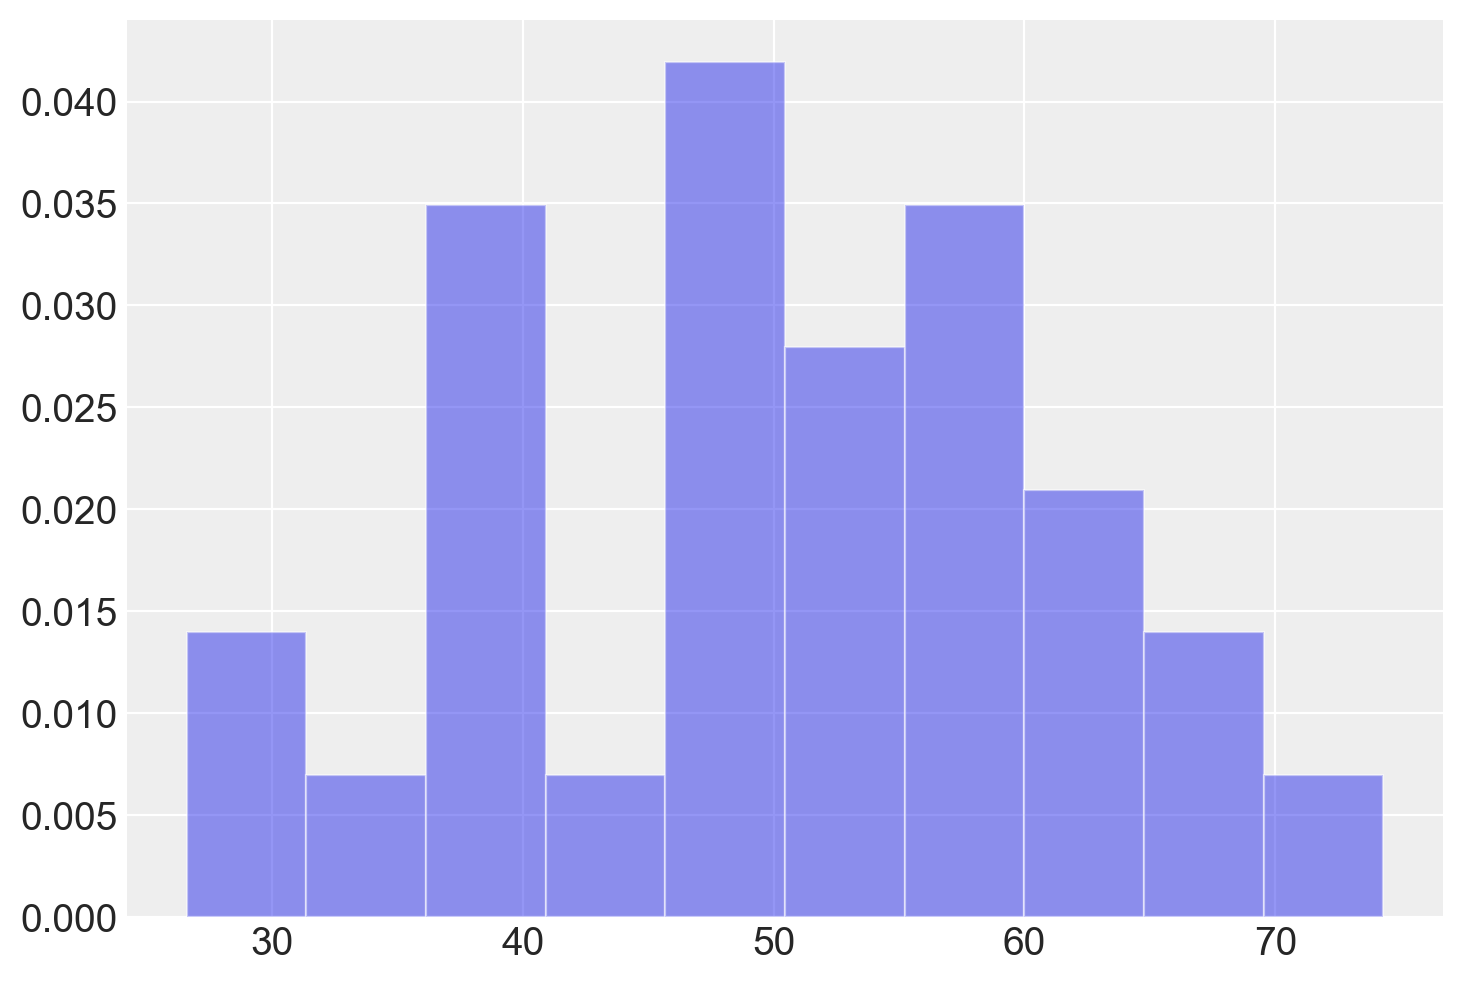

In [108]:
plt.hist(sample_data, density=True, alpha=0.5);

Un modo per affrontare il problema della stima di $\mu$ utilizzando un approccio frequentista è attraverso la stima puntuale. La stima puntuale prevede l'utilizzo di un singolo valore, come ad esempio la media campionaria, per rappresentare il parametro della popolazione sconosciuto. 

La media campionaria, $\hat{\mu}$, è una stima puntuale comunemente usata per la media della popolazione, $\mu$. Viene calcolata come la somma dei valori campionari, $x_1, x_2, ..., x_n$, divisa per la dimensione del campione, $n$:

$$\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i.$$

Per i dati dell'esempio, abbiamo

In [109]:
sample_mean = np.mean(sample_data)
sample_mean

50.56754147515825

Tuttavia, le stime puntuali da sole non forniscono una caratterizzazione completa dell'incertezza relativa alla stima. Per quantificare questa incertezza, l'approccio frequentista utilizza  l'intervallo di confidenza. Un intervallo di confidenza è una stima dell'intervallo probabile del vero parametro della popolazione basata sui dati osservati, e viene costruito aggiungendo e sottraendo un margine di errore dalla stima puntuale: 

$$\hat{\mu} \pm m = [\hat{\mu} - m, \hat{\mu} + m].$$

Il margine di errore è determinato dal livello di confidenza desiderato e dalla dimensione del campione, e riflette la variabilità nei dati del campione. Ad esempio, un intervallo di confidenza del 95% indica che la procedura che abbiamo usato produce un risultato corretto (ovvero il fatto che il vero parametro della popolazione si trovi all'interno dell'intervallo) nel 95% dei casi.

Il margine di errore è determinato dal livello di confidenza desiderato, $1-\alpha$, e dalla dimensione del campione, $n$. Riflette la variabilità nei dati del campione ed è calcolato tipicamente utilizzando l'errore standard, $SE$, della stima puntuale:

$$m = t_{1-\frac{\alpha}{2}, n-1} \times SE,$$

dove $t_{1-\frac{\alpha}{2}, n-1}$ è il valore critico della distribuzione $t$ con $n-1$ gradi di libertà per il livello di confidenza desiderato.

L'errore standard della media del campione è calcolato come la deviazione standard del campione, $\sigma$, divisa per la radice quadrata della dimensione del campione:

$$SE = \frac{\sigma}{\sqrt{n}}.$$

Per i dati dell'esempio, la deviazione standard del campione è

In [110]:
sample_stddev = np.std(sample_data, ddof=1)
sample_stddev

11.569556713215302

L'errore standard della media è

In [111]:
standard_error = sample_stddev / np.sqrt(sample_size)
print(standard_error)

2.5870315280288456


L'errore standard della media rappresenta una stima della deviazione standard della distribuzione delle medie campionarie per campioni di dimensione $n$ (in questo caso, $n$ = 20).

Supponiamo di voler avere un livello di confidenza del 95%. Per trovare il valore critico della distribuzione $t$ di Student, dobbiamo trovare il valore della statistica $T$ che lascia il 2.5% dell'area sotto la coda a sinistra e il 2.5% dell'area sotto la coda a destra della distribuzione $t$ di Student con 19 gradi di libertà.

In [112]:
degrees_of_freedom = sample_size - 1
t_val = st.t.ppf(0.975, degrees_of_freedom)
print(t_val)

2.093024054408263


Il margine d'errore è uguale a 

$$t \cdot SE$$

ovvero

In [113]:
margin_of_error = t_val * standard_error
print(margin_of_error)

5.4147192176769385


L'intervallo di confidenza frequentista è uguale a 

$$\text{stima del parametro} \pm \text{margine d'errore}$$

ovvero

$$\bar{x} \pm t_{\text{critico}} \frac{s}{\sqrt{n}}.$$

Per i dati dell'esempio otteniamo

In [114]:
confidence_interval_lower = sample_mean - margin_of_error
confidence_interval_upper = sample_mean + margin_of_error
confidence_interval = [confidence_interval_lower, confidence_interval_upper]
print(confidence_interval)

[45.15282225748131, 55.98226069283519]


Interpretiamo questo risultato dicendo che la procedura utilizzata per calcolare l'intervallo $[42.99, 53.23]$ include $\mu$ nel 95% dei casi.

La figura successiva mostra la distribuzione dei dati, la stima di $\mu$ (ovvero, la media del campione) e l'intervalli di confidenza al 95%.

In [116]:
def visualize_output(sample_data, sample_mean, interval, type_interval):
    plt.hist(sample_data, density=True, alpha=0.5)
    plt.axvline(x=sample_mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=interval[0], color='g', linewidth=2)
    plt.axvline(x=interval[1], color='g', linewidth=2)
    plt.legend(['Sample Mean', f'{type_interval} interval'])
    plt.show()

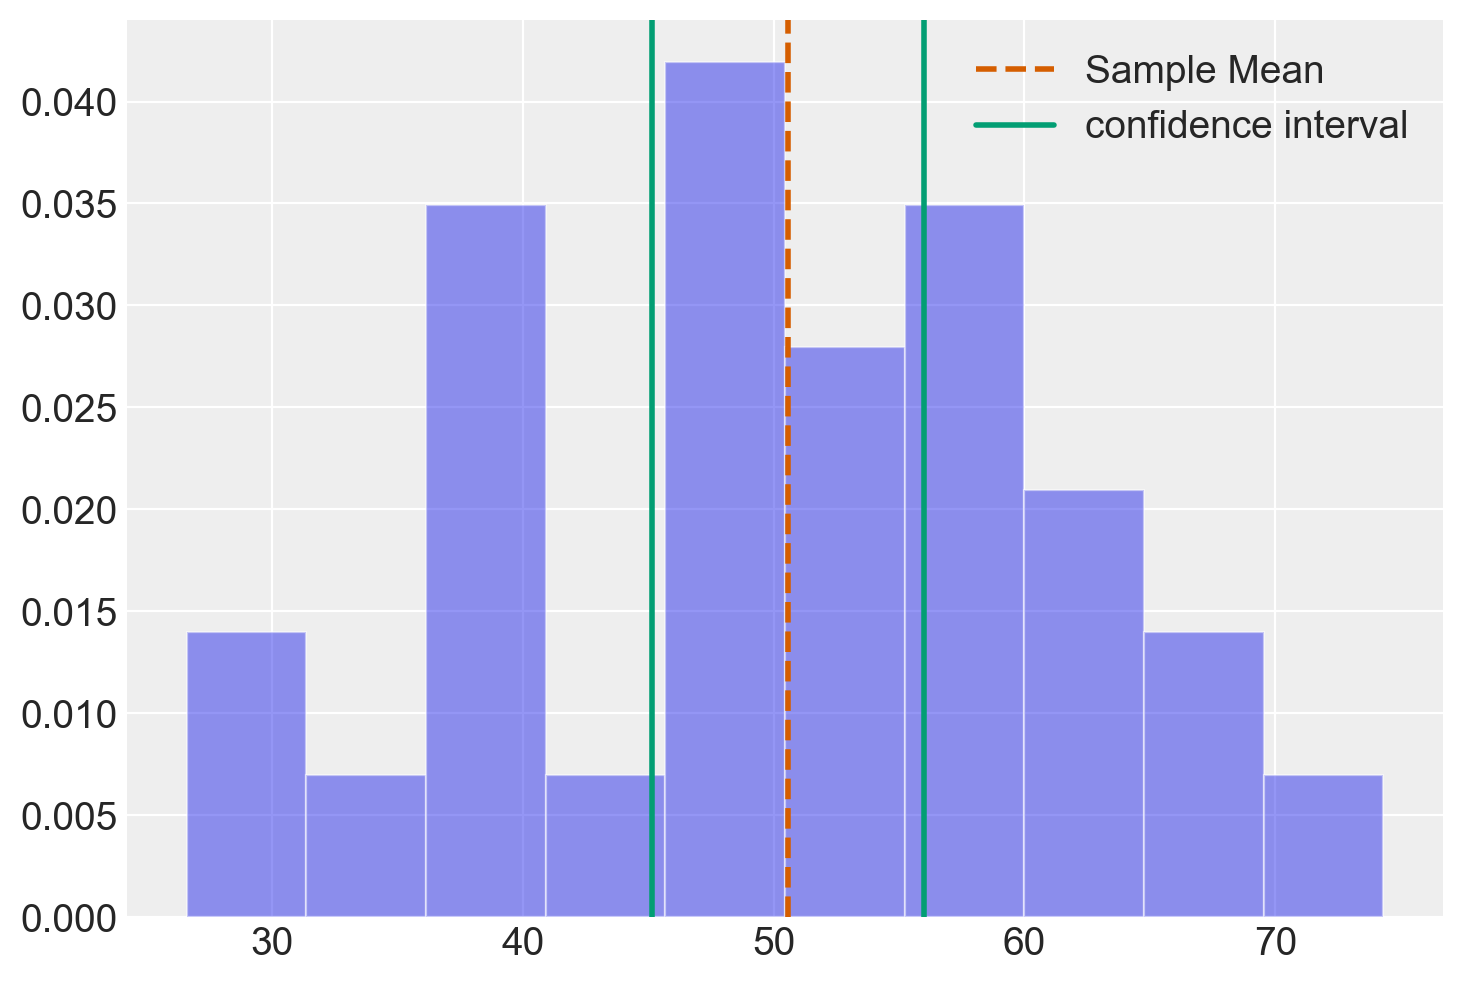

In [117]:
visualize_output(sample_data, sample_mean, confidence_interval, 'confidence')


### Intervallo di credibilità

In [118]:
model = pm.Model()

with model:

    mu = pm.Normal("mu", mu=sample_mean, sigma=20)
    sigma = pm.HalfNormal("sigma", 20)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=sample_data)

In [119]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [120]:
az.summary(idata, hdi_prob=0.95, round_to=2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk   
mu     50.52  2.26     46.15      54.84       0.04     0.03   3682.75  \
sigma  12.01  1.67      9.02      15.28       0.03     0.02   3344.68   

       ess_tail  r_hat  
mu      2387.80    1.0  
sigma   2708.95    1.0

Si noti che, per i dati considerati e per come il modello bayesiano è stato specificato, l'intervallo di credibilità è molto simile all'intervallo di confidenza frequentista. Tuttavia, l'interpretazione è più semplice: con un grado di fiducia soggettivo del 95%, possiamo affermare che la media della popolazione è contenuta nell'intervallo trovato.

## Commenti e considerazioni finali

Secondo {cite}`hoekstra2014robust`, gli intervalli di fiducia sono spesso mal interpretati. Il livello di confidenza del 95% si riferisce alla certezza che, a lungo termine, il 95% degli intervalli di fiducia includerà il parametro sconosciuto. Non si può dire nulla riguardo ad uno specifico intervallo di fiducia, che potrebbe includere o escludere il parametro sconosciuto, ma il ricercatore non può sapere quale delle due opzioni sia quella corretta. Inoltre, non esiste alcuna relazione tra la varianza e la media di un campione, quindi non possiamo dedurre che un intervallo di fiducia più stretto sia anche più preciso. In un contesto frequentista, la precisione si riferisce solo al livello di copertura a lungo termine fornito dalla procedura di generazione degli intervalli di fiducia e non riguarda il singolo intervallo osservato. Di conseguenza, un intervallo di fiducia molto stretto potrebbe essere anche molto lontano dal vero valore del parametro sconosciuto.